In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *
from IPython.display import display, Math
from numba import jit, njit
from scipy.constants import G, h, c
from scipy.constants import k as kb
import utils

# Finding the flux of the star:

In the previous notebook (Von Zeipel Theorem for an Oblate Star), we found a function that tells us the temperature across the star.

We now need to find a function $F(x,y)$ which gives us the flux of the star at different x and y positions on the projected surface of the star. To do this rigorously, we should use Planck's Law, which gives us the spectral flux density, and integrate across our observed bandpass.

$$B(\lambda, T) = \cfrac{2 h c^2}{\lambda^5} \frac{1}{\exp\left[\frac{h c}{\lambda k_B T}\right] - 1}$$

***

Let's code up Planck's Law into a python function for convenience. We have also written a function for temperature from the previous notebook:

In [2]:
@njit
def f(omega):
    return 1 - ((2/3)**(-3/2) * omega) / (3*np.sin(np.arcsin((2/3)**(-3/2) * omega) / 3))

@njit
def planck(l, t):
    return 2.*h*c**2/l**5/(np.exp(h*c/(l*kb*t)) - 1.)

@njit
def von_zeipel(x, y, omega, beta, tpole):
    a= (1.-x**2-y**2)
    b = (1.-f(omega))
    
    temp = tpole * b**(2*beta) * ((-a*b**2 + (a-1)*(-(omega**2)*(a*b**2 - a + 1)**(3./2.) + 1.)**2.) / (-a*b**2 + a - 1)**3)**(beta/2)
    return temp

## Pixellization of the star:

In order to plug numbers into our flux function, we must first grid up the star as a bunch of pixels. To do this, we can use starry's built in pixel transforms. Let's create a default map:

In [3]:
%matplotlib inline
import starry
import numpy as np
from scipy.spatial.transform import Rotation as R
starry.config.lazy = False
starry.config.quiet = True

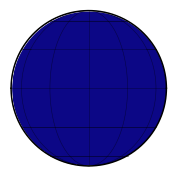

In [4]:
map0 = starry.Map(ydeg=10,udeg=2)
map0.show()

The get_pixel_transform function pixellizes the surface of the star and returns an array of latitudes and longitudes, which we can plot on a flat surface using a Mollweide projection:

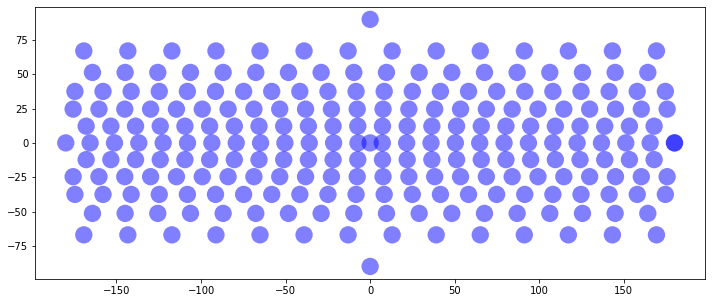

In [5]:
lat, lon, Y2P, P2Y, Dx, Dy = map0.get_pixel_transforms()
fig, ax = plt.subplots(1, figsize=(12, 5))
im = ax.scatter(lon, lat, s=300, c='b', alpha=0.5, ec="none", cmap="plasma")

Now we can plug these pixels into the temperature function and then Planck's Law to get our fluxes:

In [6]:
phi = np.radians(lat)
theta = np.radians(lon)
x = np.cos(phi) * np.cos(theta)
y = np.cos(phi) * np.sin(theta)
z = np.sin(phi)


temps = von_zeipel(x, y, 0.23, 0.22, 7600)
flux = planck(5.1e-7, temps)

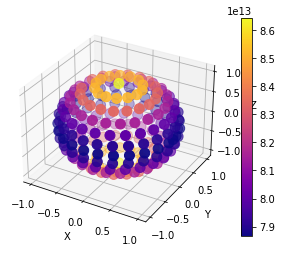

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p = ax.scatter(x, y ,z, s=100, c=flux, cmap='plasma')
plt.colorbar(p)

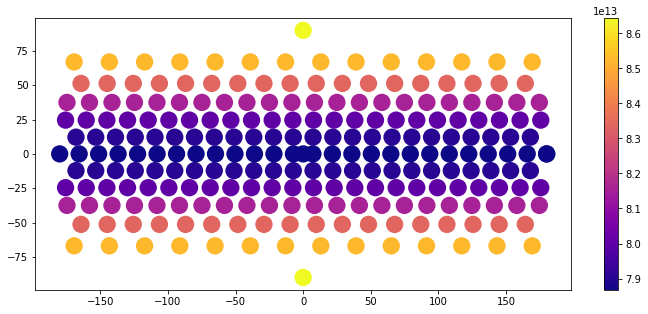

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 5))
im = ax.scatter(lon, lat, s=300, c=flux, alpha=1, ec="none", cmap="plasma")
plt.colorbar(im)

## Conversion to spherical harmonics in starry:

Using the conversions in starry, we can convert this to spherical harmonics:

In [9]:
y = P2Y.dot(flux)
map0[1:, :] = y[1:] / y[0]
map0.amp = y[0]

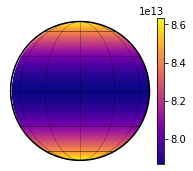

In [10]:
map0.show(colorbar=True)

Now let's see the poles of the star:

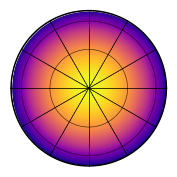

In [11]:
map0.obl = 0
map0.inc = 0
map0.show()

And an animation of the star rotating:

In [12]:
theta = np.linspace(0, 360, 50)
map0.inc = 90
map0.show(theta=theta)

Now let's create a hot-Jupiter planet orbiting around this star (modeled after Wasp-33b):

In [13]:
G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8
M_star = 1.59
R_star = 1.561

star = starry.Primary(map0, m=M_star, r=R_star,prot=100000)

planet = starry.kepler.Secondary(map=starry.Map(lmax=2),
    m=0,  # mass in solar masses
    r=0.1087*star.r,  # radius in solar radii
    porb=1.2198681,  # orbital period in days
    inc=90,#88.01,
    Omega=92,  # longitude of ascending node in degrees
    ecc=0.0,  # eccentricity
    w=0,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

system = starry.System(star, planet)

### Creating lightcurves:

Finally, let's create a lightcurve with the above system:

NOTE: the below lightcurve is not yet correct because it uses starry's internal fluxes, which assumes the star to be a sphere. To do this rigorously for an oblate star, we must integrate properly over an ellisoidal star. 

In [14]:
time = np.linspace(planet.porb-0.15, planet.porb+0.15, 500)

In [15]:
%%time
flux_star, flux_planet = system.flux(time, total=False)

CPU times: user 2.2 s, sys: 660 ms, total: 2.86 s
Wall time: 17.1 s


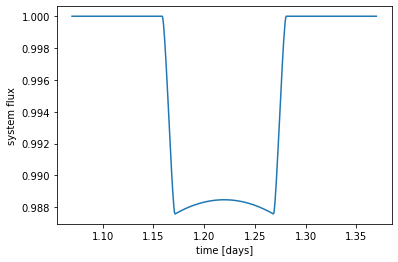

In [16]:
plt.plot(time, flux_star/flux_star[0])
plt.xlabel("time [days]")
plt.ylabel("system flux");

Gravity darkened lightcurves can look very strange indeed! And an animation (to-scale) of this planetary system:

In [17]:
system.show(t=np.linspace(0, 2, 50), window_pad=4, figsize=(8, 8))

Finally, let's compare to an existing code, pytransit to see how our map compares:

In [18]:
import pytransit
from pytransit import OblateStarModel, QuadraticModel
print(pytransit.__file__)
tmo = OblateStarModel(sres=1000, pres=10, rstar = 1.561)
tmc = QuadraticModel(interpolate=False)

time = np.linspace(1.2198696-0.15, 1.2198696+0.15, 500)
tmo.set_data(time)
tmc.set_data(time)

/Users/shashank/anaconda3/lib/python3.7/site-packages/PyTransit-2.5.1-py3.7.egg/pytransit/__init__.py


0.02640963225631405
0.026409632256314097


/Users/shashank/anaconda3/lib/python3.7/site-packages/PyTransit-2.5.1-py3.7.egg/pytransit/models/osmodel.py:94: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


array([nan, nan, nan, ..., nan, nan, nan])

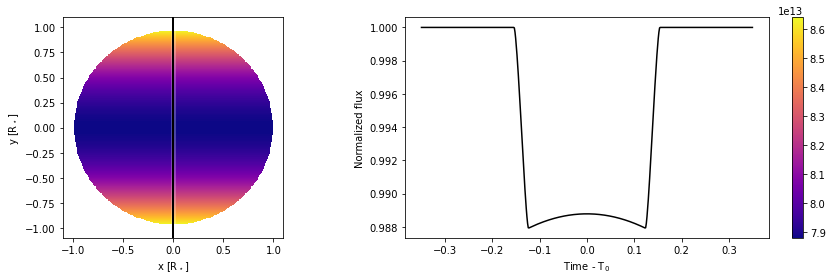

In [19]:
omega_s = np.abs(0.23)#/(np.sin(np.radians(90-inc))))
k = np.array([0.1087])
p_rot = (2*np.pi*(R_star*Rsun)**(3/2))/(omega_s*(G_mks*M_star*Msun)**(1/2)*(60*60*24))
t0, p, a, i, az, e, w = 0.0, 1.2198696, 3.614, 90*(np.pi/180), 92*(np.pi/180.), 0.0, 0.0 #real t0 is 2458792.63403
rho, rperiod, tpole, phi, beta = 0.59, p_rot,7600, (0)*(np.pi/180.), 0.22
b=0
tmo.visualize(0.10714, b, 90*(np.pi/180.), rho, rperiod, tpole, phi, beta, np.array([0,0]), ires=256)

Although the lightcurve and orientation of the planet is different, we can see that the map of the star in pytransit and the map of the star in our code match very well. 